# Handwritten Digit Recognizer

# AI-0029

The main challenges in this project was:
1. To find the common features of a digit which persist in all the different (actually numerous) types of handwriting 
2. Unlike typed digits, handwritten digits are frequently misaligned, ill-shaped and zigzaged

Throughout this project my main objective was to overcome these two.

# Data and dependencies

Importing the libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


Reading the data, check for NA cells and see the distribution

False


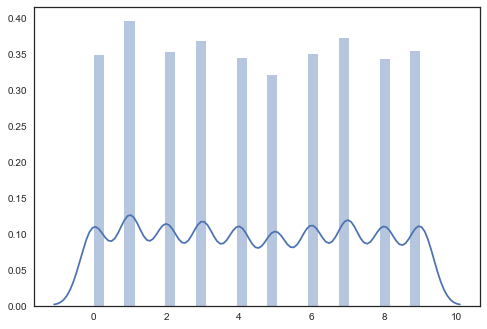

In [15]:
train = pd.read_csv('train.csv')
target = train[['label']]
feature =  train.drop(labels = ["label"],axis = 1) 
print(train.isnull().values.any())
sns.distplot(target)

These are the pixel value of an image, right? So, lets reshape the dataset and make them that.
Its also important to represent the data into the most 'realistic' form to be tangible for us, and perhaps the machine!!

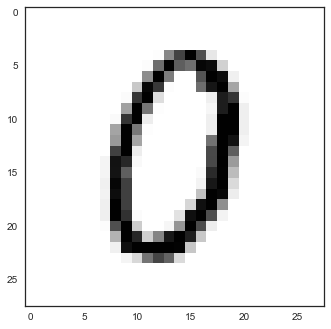

In [16]:
feature = feature.values.reshape(-1,28,28,1)
g = plt.imshow(feature[5][:,:,0])

# Preprocessing:

So, the dataset balanced and do not have any single NA cell. thats awesome!! Let's proceed then. We know that the range of 8 bit pixel values are 0 to 255. which means, we can scale all the values between 1 and 0. This is convinient structure for many algorithms. (Min Max Scaling) This step is mandatory for many algorithms to perform well.

In [17]:
feature = feature/255.0

# So, Let's build the model!!

We will start with a sequential model. As they are good with time invariant data. like, IMAGE!! 

In [ ]:
model = Sequential()

Now, As we are working with image data, what's better than the CNN model? So, let's add two convolution layers first. The parameters used are the most commonly used ones.

In [ ]:
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

Now, After this layer, we assume that the filters extracted the most basic features. Like straight lines of different directions. Tthis is what convolution layers do- they extracts features- simple to complex. 
But as a penalty, we have a huge load of data now. It would be better if we can reduce the load, but without loosing the vital informations. Maxpool layer does the exact same thing. It has another advantage- it compensates the misalignment and "zigzag problem" to some extent. 

In [ ]:
model.add(MaxPool2D(pool_size=(2,2)))

Now we got rid of some extra data. Thats a relief. But As all the nodes are connected to each other in some way, we have a lot of connections now. Some are strong and others are weak. These weak connections may cause overfitting in the future. So, let's get rid of some connections.

In [ ]:
model.add(Dropout(0.25))

Now we have a decent chunk of data with a decent number of connections. Thats great. But so far what kind of features did we extract from the digits' image? only some lines or dots i guess.
Let's stop for some minutes and think- what types of features makes the digits distinct from one another? I think there are 3 types of 'Strokes' each digit has. They are:
1. Straight lines
2. Curves and Circles
3. Joints.

Among these, joints are the result of the previous twos. who are simpler in nature. So, we can add another stack of layers to add higher dimensions in the data.

In [ ]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

So, what's now?
I guess Curves are more complex than Straight lines. In that sense, we should add another stack. But, hey, these are all just some hypothesises, right? lets see how this setup goes.
So, we can stop going to the "higher dimensional" features and take the output of the previous layer as feature sets. As they are individual features, we don't need to keep the "3D" or "image-style" format of the data. Let's flatten them to make them generalized. and then feed them into a layer of simple ANNs.

In [ ]:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))

Now, We need the prediction. To obtain that, We must add one more layer of simple ANNs. Each node of that layer will represent one target class. So, the number of node will be 10. In this time, we need softmax as the activation function, cause that will give us the probability of each class and also, keep the model analytic. So, Let's do that. But I'll be cautious about the overfitting first.

In [ ]:
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Now, the Architecture is ready. we need to set an optimizer and compile the model. In addition, I will add a learning rate reduction function to keep things precise where necessary.

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 86

Now its time to split the dataset into train and test. I will set the epoch to 30. and set batch size to 86. Its higher than the average. Cause the size of each image is small.

In [ ]:
target = to_categorical( target, num_classes = 10)

X_train, X_val, Y_train, Y_val = train_test_split(feature, target, test_size = 0.1)

Now, I will use the image data generator function of keras. this will rotate, zoom, shift the whole dataset randomly. So, we will have a feeling of having a large dataset. And this is important for the selection of the features

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False
        zca_whitening=False,
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

Here, the rotation, zoom, shift etc are kept at minimum. because, if you see the data, you'll find that the digits are already somewhere roteted and elswhere shifted. Which is a big problem of handwritings. flips are cancelled cause- obviously, they won't be the same digit if we do that..

# 3...2...1... GO!!!

In [ ]:
print('Started DataGen')
datagen.fit(X_train)
print('Finished Datagen fitting. Started Model Fitting')
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
print('Finished Model fitting')

# Lets predict the test dataset now

In [ ]:
TEST_data = pd.read_csv('test.csv')

TEST_data = TEST_data/255.0
TEST_data = TEST_data.values.reshape(-1,28,28,1)
print('Started Prediction')
ansr = model.predict(TEST_data)

ansr = np.argmax(ansr,axis = 1)
ansr = pd.Series(ansr,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),ansr],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)
print('Done Exporting The Result')


This result has an accuracy of 99.59% which is pretty good.

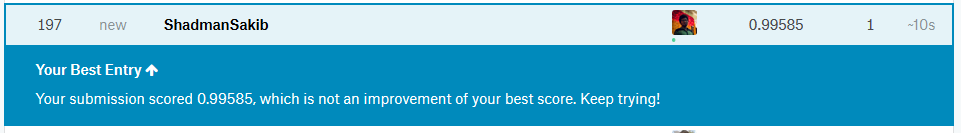

# Further thoughts about the model

At this point, I had three options to further improve the model:
1. Increasing the epoch
2. Further preprocessing of the data
3. Changing the CNN's parameters and structure.

# 1. Increasing the epoch: Will it really help?

To find the answer, I ploted the accuracy vs epoch graph and found out that the accuracy was actually about to saturate. But we can go for it anyway.. It might rise about 0.1-0.2% (The figure shown is not generated by this report. Its taken from the Notebook where I worked for this project. If you run all the previous code and then the code written in the next cell, you will get the same image)

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

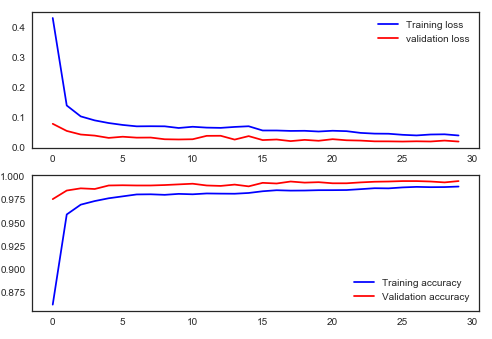

# 2. Further preprocessing of the data:
The data is already scaled. So i didn't go for anything more. But I tried the batch normalization layer. After a bit of tinkering, the model looked like this: 

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

But the accuracy didn't increase.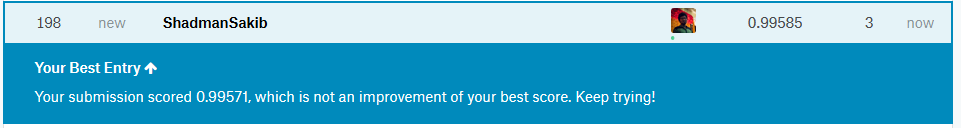

# 3. Changing the CNN's parameters and structure:

After some random thoughts, I changed the model like the following:

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

There is only one major change, in fact. That is the size of the pool_size of the maxpool layer. As we know, a side effect of this layer is reduction of the effect of shifting and roughness ["Deep Learning" by Ian GoodFellow]. If we see the sample figure at the top of this report, we will find that the average shifting of the distance of two strokes of a same digit is around 5 pixels. For this reason, I tried with the pool size (5,5). But it didn't help increasing the accuracy. Rather downgraded it significantly.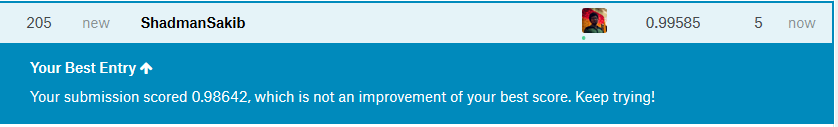